<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, accuracy_score


In [ ]:
tf.config.list_physical_devices('GPU')

[]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Generate random data

In [ ]:
size_input = 784
size_hidden1 = 256
size_hidden2 = 128
size_output = 10

number_of_train_examples = 6000
number_of_test_examples = 1000

(50000, 28, 28) (50000,)
Train dimension:
(50000, 784)
Test dimension:
(10000, 784)
Val dimension:
(10000, 784)
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)
Test labels dimension:
(10000, 10)


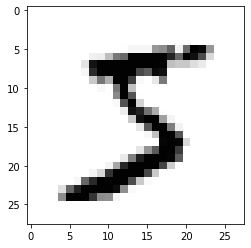

In [ ]:
'''
X_train = np.random.randn(number_of_train_examples , size_input)
y_train = np.random.randn(number_of_train_examples)
X_test = np.random.randn(number_of_test_examples, size_input)
y_test = np.random.randn(number_of_test_examples)
'''


def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # normalize x
    X_train = X_train.astype(float)/255.0
    X_test = X_test.astype(float)/255.0
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
## Printing dimensions
print(X_train.shape, y_train.shape)
## Visualizing the first digit
plt.imshow(X_train[0], cmap="Greys");
## Changing dimension of input images from N*28*28 to  N*784
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]))

print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)
print('Val dimension:');print(X_val.shape)

## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)
print('Test labels dimension:');print(y_val.shape)


def Accuracy(yTrue,yPred):
    return tf.keras.metrics.sparse_categorical_accuracy(yTrue, yPred)



In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)


   

## Build MLP using Eager Execution

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1,size_hidden2,size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1,self.size_hidden2, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layer1 and hidden layer2 layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer1 and hidden layer2 layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    # Initialize weights between hidden layer1 and hidden layer2 layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
    # Initialize biases for hidden layer1 and hidden layer2 layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.b1, self.b2,self.W3,self.b3]
    
  def forward(self, X,Training=False):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X,Training)
    else:
      self.y = self.compute_output(X,Training)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy()
    #print(y_true_tf.shape,y_pred_tf.shape)
    #print('succ',cce(y_true_tf, y_pred_tf).numpy())
    return cce(y_true_tf, y_pred_tf)
    #return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    #return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """    
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
    
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    
    '''

    with tf.GradientTape(persistent=True) as tape3:
      with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
          predicted = self.forward(X_train)
          current_loss = self.loss(predicted, y_train)
        grad1 = tape1.gradient(current_loss, [self.W3,self.b3])
        optimizer.apply_gradients(zip(grad1, [self.W3,self.b3]))
      grad2 = tape2.gradient(grad1,[self.W2,self.b2])
      optimizer.apply_gradients(zip(grad2, [self.W2,self.b2]))
    grad3 = tape3.gradient(grad2, [self.W1,self.b1])
    optimizer.apply_gradients(zip(grad3, [self.W1,self.b1]))
    return grad3

    '''
        
  def compute_output(self, X,Training=False):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    if(Training):
      hhat = tf.nn.dropout(hhat, 0.5)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    if(Training):
      hhat2 = tf.nn.dropout(hhat2, 0.5)

    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)


## Train Model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 100

In [ ]:
seed = [56,876,6666,7777,3452,5]

for x in seed:
  print('For Seed',x,':')

  #Default mode
  mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_output, device='tpu')
  #hidden2 = MLP(size_hidden2, size_hidden2, size_output, device='gpu')
  time_start = time.time()

  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    acc = 0
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(x)).batch(64)
    accuracies = []
    for inputs, outputs in train_ds:
      preds = mlp_on_default.forward(inputs,True)
      loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      acc = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      lt = lt + mlp_on_default.loss(preds, outputs)
      mlp_on_default.backward(inputs, outputs)
      
    Accpred = mlp_on_default.forward(X_train)
    cat_acc = tf.metrics.CategoricalAccuracy()
    accuracies.append(cat_acc(Accpred, y_train))
    ValAccuracies = []
    Accpred = mlp_on_default.forward(X_val)
    cat_acc = tf.metrics.CategoricalAccuracy()
    ValAccuracies.append(cat_acc(Accpred, y_val))
    if((epoch+1)%5 == 0):
      print('Number of Epoch = {} - Average Loss:= {} Validation Accuracy:= {} Training Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0],np.mean(ValAccuracies)*100,np.mean(accuracies)*100))

  time_taken = time.time() - time_start
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

  #inference
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  #test_loss_total = 0.0
  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=epoch*(x)).batch(64)
  cat_acc = tf.metrics.CategoricalAccuracy()
  accuracies = []

  for inputs, outputs in test_ds:
    preds = mlp_on_default.forward(inputs)
    test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
    cat_acc = tf.metrics.CategoricalAccuracy()  
    accuracies.append(cat_acc(preds, outputs))


  print('Inference Loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))
  print('Inference Accuracy: {:.4f}'.format(np.mean(accuracies)*100))

For Seed 56 :
Number of Epoch = 5 - Average Loss:= 0.19205939453125 Validation Accuracy:= 51.05999708175659 Training Accuracy:= 52.056002616882324
Number of Epoch = 10 - Average Loss:= 0.1804155078125 Validation Accuracy:= 55.21000027656555 Training Accuracy:= 55.72599768638611
Number of Epoch = 15 - Average Loss:= 0.175452734375 Validation Accuracy:= 55.970001220703125 Training Accuracy:= 56.51000142097473
Number of Epoch = 20 - Average Loss:= 0.17415708984375 Validation Accuracy:= 56.37999773025513 Training Accuracy:= 56.94800019264221
Number of Epoch = 25 - Average Loss:= 0.1699783984375 Validation Accuracy:= 64.3999993801117 Training Accuracy:= 64.82200026512146
Number of Epoch = 30 - Average Loss:= 0.16621732421875 Validation Accuracy:= 64.82999920845032 Training Accuracy:= 65.3760015964508
Number of Epoch = 35 - Average Loss:= 0.16236884765625 Validation Accuracy:= 64.99999761581421 Training Accuracy:= 65.53800106048584
Number of Epoch = 40 - Average Loss:= 0.161231416015625 Vali

KeyboardInterrupt: ignored

## One Step Inference